In [1]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms as tfm
from sklearn import metrics as skmet

%aimport dataset

ImageData = dataset.ImageData
CustomCrop = dataset.CustomCrop

In [3]:
views = ['pdaRelatedView', 'pdaView']
modes = ['2d', 'color', 'color_compare']
bs = 16  # batch size for training
num_workers = 5  # number of parallel data loading workers
res = 224 # pixel size along height and width
device = torch.device('cpu')
num_classes = 3

In [4]:
tfms = tfm.Compose([
    tfm.Resize(res),
    tfm.ToTensor()
])

In [6]:
df_frame = pd.read_csv('../label_data/20220822_frame.csv')
df_video = pd.read_csv('../label_data/20220822_video.csv')
df_study = pd.read_csv('../label_data/20220822_study.csv')
df_patient_study = pd.read_csv('../label_data/20220822_patient_study.csv')
df_patient = pd.read_csv('../label_data/20220822_patient.csv')

In [7]:
df_patient.columns, df_patient_study.columns, df_study.columns, df_video.columns, df_frame.columns

(Index(['patient_id', 'num_studies'], dtype='object'),
 Index(['patient_id', 'patient_type', 'study', 'num_videos'], dtype='object'),
 Index(['patient_type', 'study', 'num_videos', 'num_frames'], dtype='object'),
 Index(['external_id', 'patient_type', 'num_frames', 'view', 'mode',
        'diagnosis', 'study', 'mp4_path'],
       dtype='object'),
 Index(['patient_type', 'external_id', 'png_path'], dtype='object'))

In [8]:
# create datasets
df = df_patient.merge(df_patient_study).merge(df_study, on=['patient_type', 'study']).merge(df_video, on=['patient_type', 'study']).merge(df_frame, on=['patient_type', 'external_id'])
df

,patient_id,num_studies,patient_type,study,num_videos_x,num_videos_y,num_frames_x,external_id,num_frames_y,view,mode,diagnosis,mp4_path,png_path
0,01578f3a19fbf0f2,1,pda,study22,82,33,4825,study22_dicom35,77,nonPDAView,2d,NaN,/mnt/data/pda/superior_views/PDA/study22_dicom...,/mnt/data/pda/model_data/20220822/pda_study22_...
1,01578f3a19fbf0f2,1,pda,study22,82,33,4825,study22_dicom35,77,nonPDAView,2d,NaN,/mnt/data/pda/superior_views/PDA/study22_dicom...,/mnt/data/pda/model_data/20220822/pda_study22_...
2,01578f3a19fbf0f2,1,pda,study22,82,33,4825,study22_dicom35,77,nonPDAView,2d,NaN,/mnt/data/pda/superior_views/PDA/study22_dicom...,/mnt/data/pda/model_data/20220822/pda_study22_...
3,01578f3a19fbf0f2,1,pda,study22,82,33,4825,study22_dicom35,77,nonPDAView,2d,NaN,/mnt/data/pda/superior_views/PDA/study22_dicom...,/mnt/data/pda/model_data/20220822/pda_study22_...
4,01578f3a19fbf0f2,1,pda,study22,82,33,4825,study22_dicom35,77,nonPDAView,2d,NaN,/mnt/data/pda/superior_views/PDA/study22_dicom...,/mnt/data/pda/model_data/20220822/pda_study22_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205876,f8dd48f1f7946612,2,pda,study36,91,43,3412,study36_dicom78,97,nonPDAView,color,NaN,/mnt/data/pda/superior_views/PDA/study36_dicom...,/mnt/data/pda/model_data/20220822/pda_study36_...
205877,f8dd48f1f7946612,2,pda,study36,91,43,3412,study36_dicom78,97,nonPDAView,color,NaN,/mnt/data/pda/superior_views/PDA/study36_dicom...,/mnt/data/pda/model_data/20220822/pda_study36_...
205878,f8dd48f1f7946612,2,pda,study36,91,43,3412,study36_dicom78,97,nonPDAView,color,NaN,/mnt/data/pda/superior_views/PDA/study36_dicom...,/mnt/data/pda/model_data/20220822/pda_study36_...
205879,f8dd48f1f7946612,2,pda,study36,91,43,3412,study36_dicom78,97,nonPDAView,color,NaN,/mnt/data/pda/superior_views/PDA/study36_dicom...,/mnt/data/pda/model_data/20220822/pda_study36_...


# Visualize

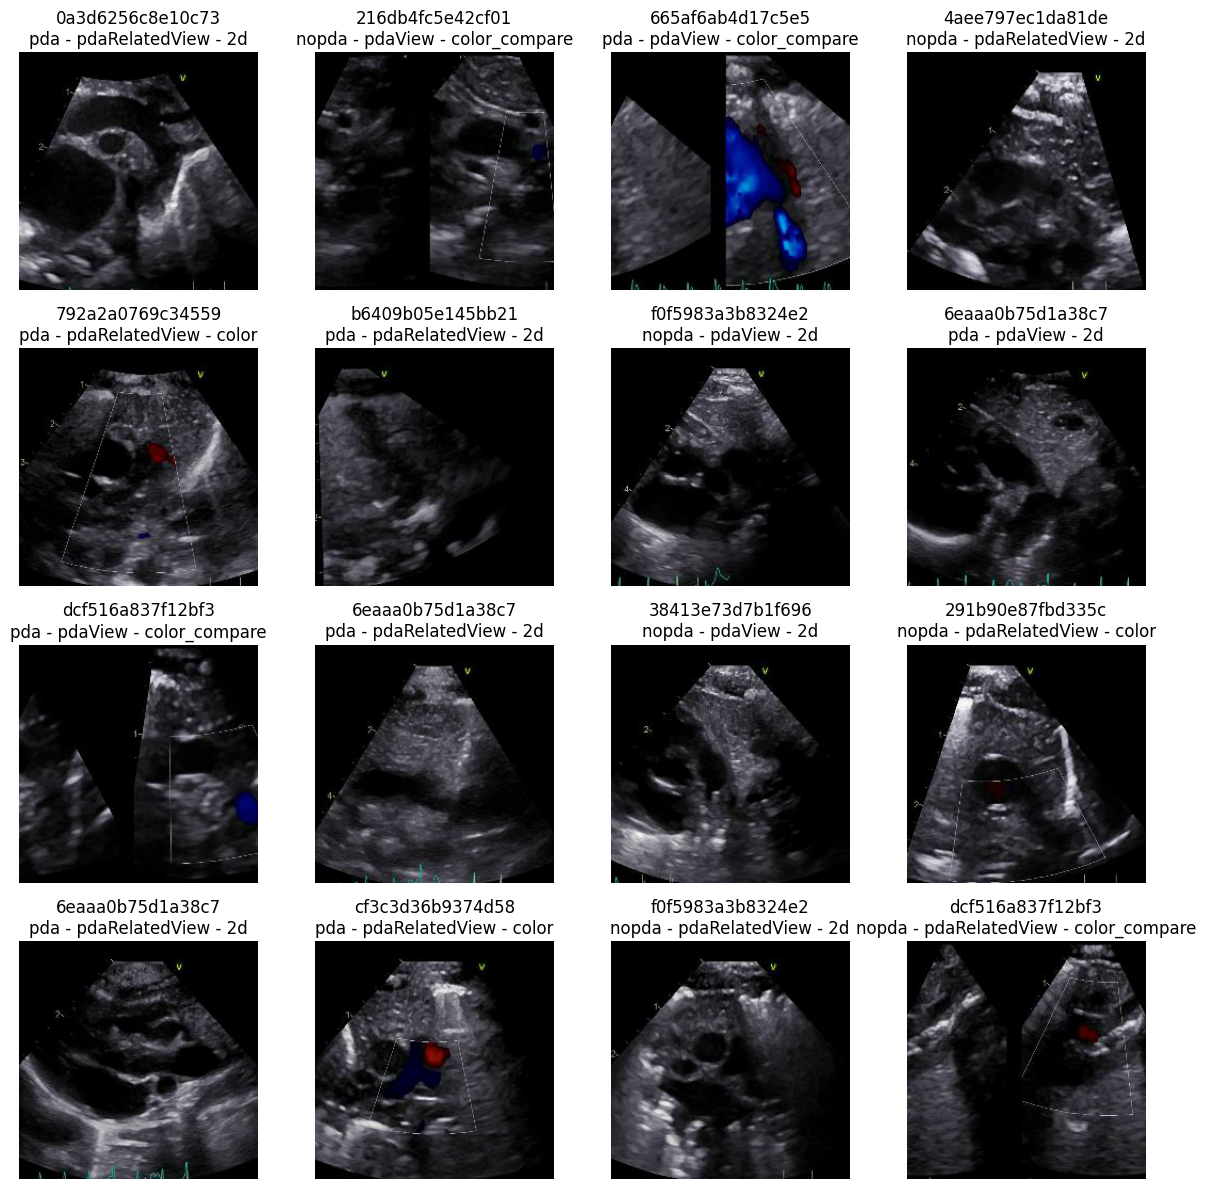

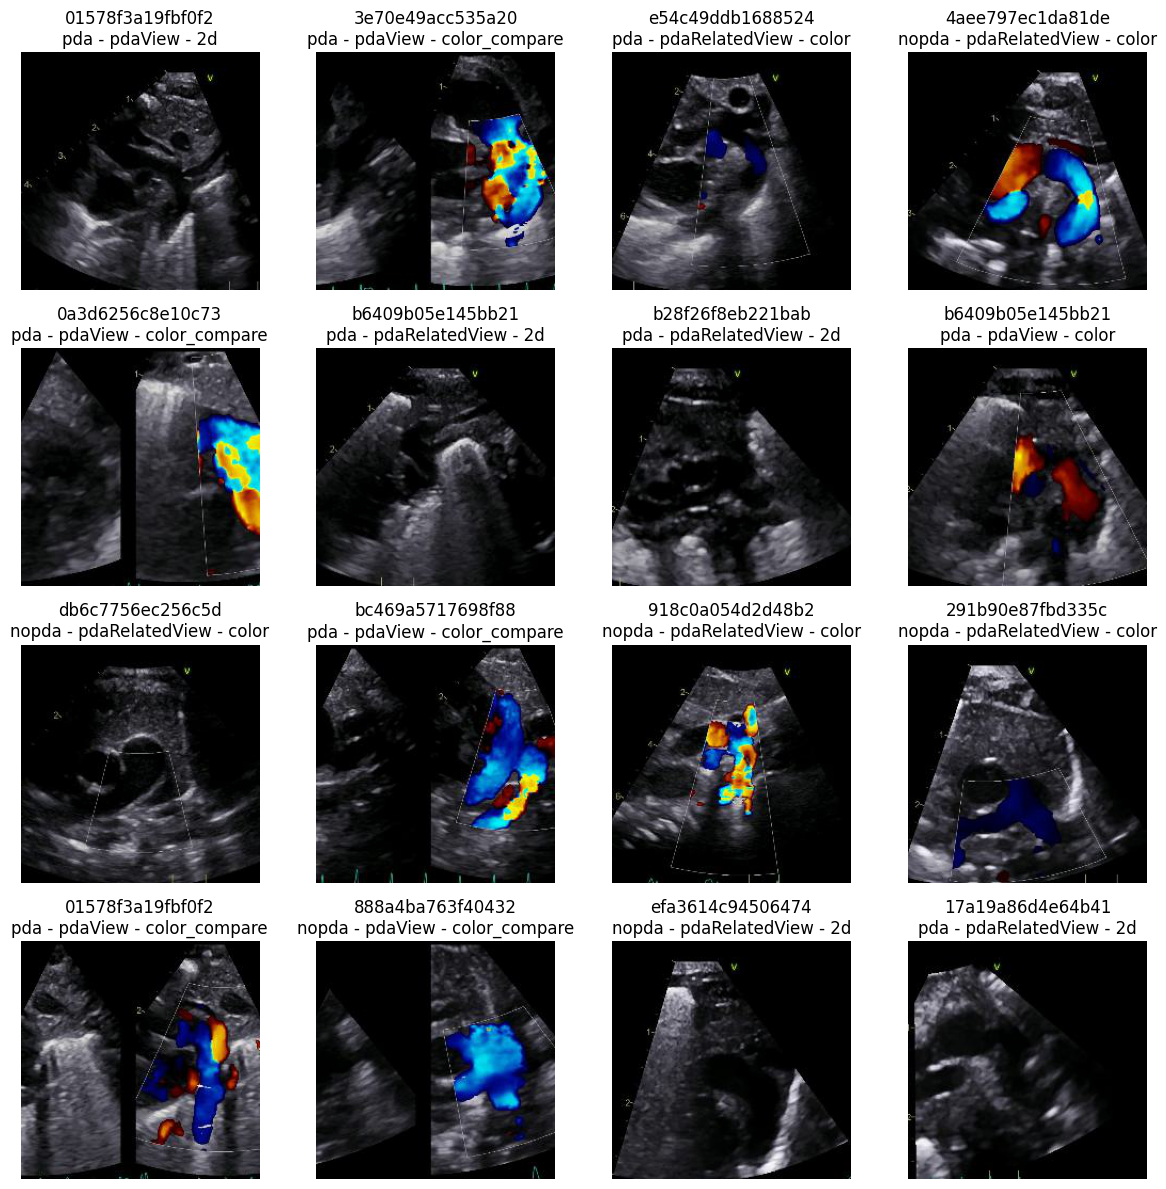

In [9]:
d = ImageData(df, transforms = tfms, mode_filter = modes, view_filter = views)
dl = DataLoader(d, batch_size=bs, num_workers=num_workers, shuffle=True)

for ix, batch in enumerate(dl):
    if ix>1:
        break
    
    ImageData.display_batch(batch, n_cols=4, height=12)

# Compute image stats

In [ ]:
# target_ls = []
# study_ls = []
# video_ls = []
# view_ls = []
# mode_ls = []
# mean_ls = []

# for ix, batch in enumerate(dl):
#     print(f"Batch {ix+1}", end = "\r")
#     inputs = batch['img'].to(device)
#     targets = batch['trg_type'].to(device).type(torch.float32)
#     target_ls.append(targets.cpu().numpy())
#     view_ls.append(batch['trg_view'].numpy())
#     mode_ls.append(batch['trg_mode'].numpy())
#     study_ls += batch['study']
#     video_ls += batch['video']
    
#     mean_ls.append(inputs.mean(dim=(-2, -1)).cpu().numpy())

In [ ]:
# df_results = pd.DataFrame(dict(
#     study = study_ls,
#     video = video_ls,
#     target = np.concatenate(target_ls), 
#     mode = np.concatenate(mode_ls),
#     view = np.concatenate(view_ls),
#     mean_ch1 = np.concatenate(mean_ls)[:,0],
#     mean_ch2 = np.concatenate(mean_ls)[:,1],
#     mean_ch3 = np.concatenate(mean_ls)[:,2]
# ))

In [ ]:
# df_agg = df_results.groupby(['mode', 'view', 'target']).agg([lambda x: str(np.quantile(x, q=[0.05, 0.95])), min, max])
# df_agg